In [1]:
# import libraries

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from IPython.display import display
from scipy.stats import beta
from itertools import product

# high-quality figures
%config InlineBackend.figure_format = 'svg'

## 1. Importar e visualizar os dados

In [3]:
# O nosso ticker é BTC-USD
BTC_USD = yf.Ticker("BTC-USD")
# Apanhamos 6 anos
data = BTC_USD.history(start="2019-01-01", end="2024-10-31")

data.head()

Open         High          Low        Close  \
Date                                                                            
2019-01-01 00:00:00+00:00  3746.713379  3850.913818  3707.231201  3843.520020   
2019-01-02 00:00:00+00:00  3849.216309  3947.981201  3817.409424  3943.409424   
2019-01-03 00:00:00+00:00  3931.048584  3935.685059  3826.222900  3836.741211   
2019-01-04 00:00:00+00:00  3832.040039  3865.934570  3783.853760  3857.717529   
2019-01-05 00:00:00+00:00  3851.973877  3904.903076  3836.900146  3845.194580   

                               Volume  Dividends  Stock Splits  
Date                                                            
2019-01-01 00:00:00+00:00  4324200990        0.0           0.0  
2019-01-02 00:00:00+00:00  5244856836        0.0           0.0  
2019-01-03 00:00:00+00:00  4530215219        0.0           0.0  
2019-01-04 00:00:00+00:00  4847965467        0.0           0.0  
2019-01-05 00:00:00+00:00  5137609824        0.0           0.0

In [5]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

Text(0.5, 1.0, 'BTC-USD Close Price')

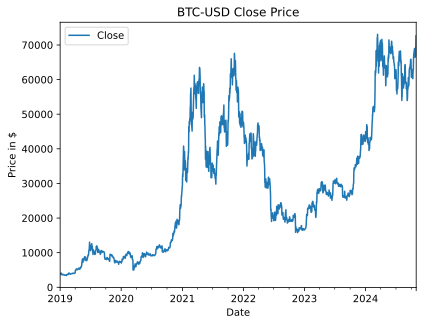

In [7]:
graph = data['Close'].plot()
graph.legend(loc='best')
graph.set_ylabel('Price in $')
graph.set_xlabel('Date')
graph.set_title('BTC-USD Close Price')

## 2. Estratégia de trading

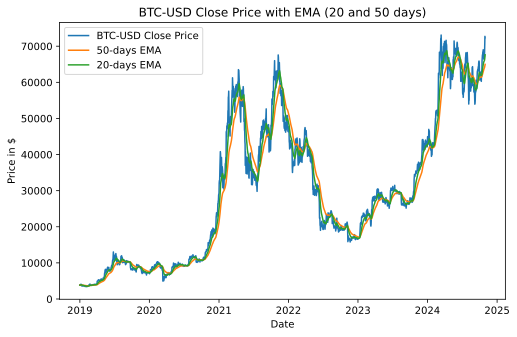

In [9]:
## visualize signal and moving average lines

start_date = '2019-01-01'
end_date = '2024-10-31'

# Calculating the short-window exponential moving average
short_ema = data['Close'].ewm(span=20, adjust=False).mean()

# Calculating the long-window exponential moving average
long_ema = data['Close'].ewm(span=50, adjust=False).mean()

# Plotting the data
fig, ax = plt.subplots(figsize=(8,5))

# Plot BTC-USD close price
ax.plot(data.loc[start_date:end_date].index, data.loc[start_date:end_date, 'Close'], label='BTC-USD Close Price')

# Plot long-window EMA
ax.plot(data.loc[start_date:end_date].index, long_ema.loc[start_date:end_date], label='50-days EMA')

# Plot short-window EMA
ax.plot(data.loc[start_date:end_date].index, short_ema.loc[start_date:end_date], label='20-days EMA')

# Add labels and legend
ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.set_xlabel('Date')
ax.set_title('BTC-USD Close Price with EMA (20 and 50 days)')

plt.show()

In [10]:
from pickle import FALSE
def trading_strategy(data):
    # Define your trading strategy based on the historical data
    # Example: Sell when the price is above the 50-day moving average, buy otherwise
    signals = pd.DataFrame(index=data.index)
    signals['Signal'] = np.where(data['Close'] < data['Close'].ewm(span=200, adjust=FALSE).mean(), 1, 0)
    return signals

In [12]:
# Perform backtesting
def backtest(data, signals):
    # Combine the historical data with the trading signals
    df = pd.concat([data, signals], axis=1).dropna()

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Calculate cumulative returns
    df['Cumulative Return'] = (1 + df['Return']).cumprod()

    # Calculate portfolio value
    df['Portfolio Value'] = df['Cumulative Return'] * initial_investment

    # Calculate risk-free rate (assumed to be 0 in this example)
    risk_free_rate = 0

    # Calculate metrics
    num_trading_days = len(df)
    returns = df['Return']
    cumulative_returns = df['Cumulative Return']
    portfolio_value = df['Portfolio Value']

    # Annualized metrics using 365 days
    annual_returns = (cumulative_returns.iloc[-1]) ** (365 / num_trading_days) - 1
    volatility = returns.std() * np.sqrt(365)  # Annualized volatility
    sharpe_ratio = (annual_returns - risk_free_rate) / volatility
    cagr = (cumulative_returns.iloc[-1]) ** (365 / num_trading_days) - 1
    variance = returns.var() * 365  # Annualized variance
    #Filtering only valid returns in order to CVaR function
    valid_returns = returns.dropna()
    percentile_5 = np.percentile(valid_returns, 5)
    filtered_returns = valid_returns[valid_returns <= percentile_5]
    cvar = filtered_returns.mean() * 365 if not filtered_returns.empty else np.nan

    return df, sharpe_ratio, cagr, cumulative_returns, variance, cvar


## 2. Aplicação das regras definidas aos dados

In [14]:
# Define initial investment amount
initial_investment = 10000

# Perform the trading strategy
signals = trading_strategy(data)

# Perform backtesting and calculate metrics
backtest_results, sharpe_ratio, cagr, cumulative_returns,  variance, cvar = backtest(data, signals)

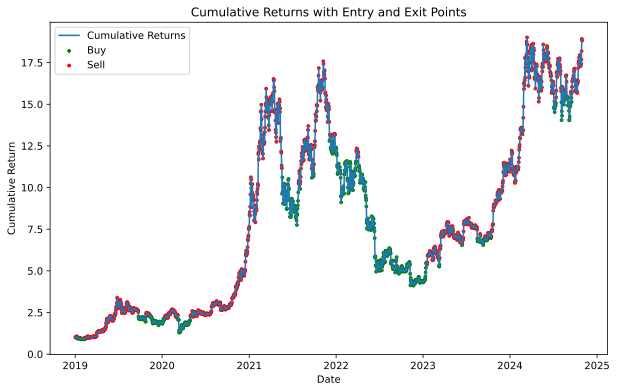

In [19]:
# Plot the cumulative returns with entry and exit points
plt.figure(figsize=(10, 6))
plt.plot(backtest_results.index, cumulative_returns, label='Cumulative Returns')
plt.scatter(backtest_results[backtest_results['Signal'] == 1].index, backtest_results[backtest_results['Signal'] == 1]['Cumulative Return'], color='green', s=8, label='Buy')
plt.scatter(backtest_results[backtest_results['Signal'] == 0].index, backtest_results[backtest_results['Signal'] == 0]['Cumulative Return'], color='red',  s=8, label='Sell')
plt.title('Cumulative Returns with Entry and Exit Points')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(False)
plt.show()

In [20]:
# Print the calculated metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"CAGR: {cagr:.2%}")
print(f"Cumulative Returns: {cumulative_returns.iloc[-1]:.2%}")
print(f"Variance: {variance:.6f}")
print(f"CVaR: {cvar:.6f}")

Sharpe Ratio: 1.01
CAGR: 65.36%
Cumulative Returns: 1882.12%
Variance: 0.422688
CVaR: -27.924801


# RSI

In [22]:
def calculate_rsi(prices, lookback=14):

    returns = prices.diff()  # Retornos diários
    gains = returns.clip(lower=0)  # Ganhos
    losses = -returns.clip(upper=0)  # Perdas

    avg_gain = gains.rolling(window=lookback, min_periods=lookback).mean()
    avg_loss = losses.rolling(window=lookback, min_periods=lookback).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Adicionar o RSI ao DataFrame
data['RSI'] = calculate_rsi(data['Close'])
data.dropna(inplace=True)  # Remover NaNs gerados pelo cálculo do RSI


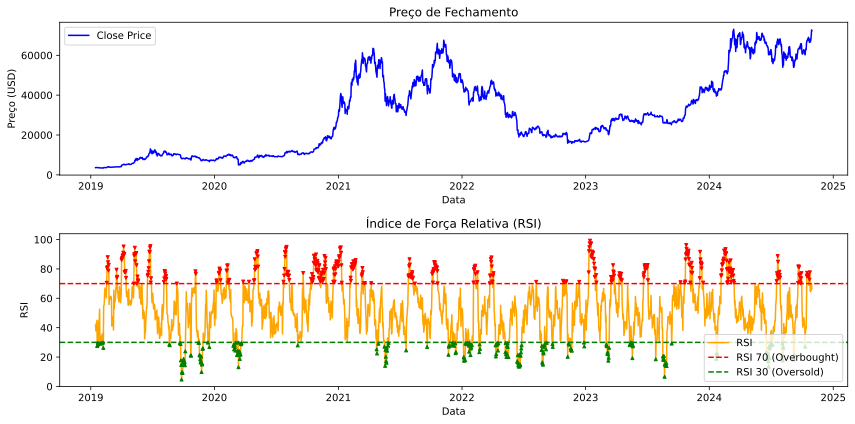

In [23]:
# Gráfico de Preços e RSI
plt.figure(figsize=(12, 6))

# Preço de fechamento
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.title('Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()

# RSI

# Sinal Base
data['Signal'] = 0

# Threshold 70-30
overbought_threshold = 70
oversold_threshold = 30

# Sinal Compra
data.loc[data['RSI'] < oversold_threshold, 'Signal'] = 1

# Sinal Venda
data.loc[data['RSI'] > overbought_threshold, 'Signal'] = -1


plt.subplot(2, 1, 2)
plt.plot(data.index, data['RSI'], label='RSI', color='orange')
plt.axhline(y=70, color='red', linestyle='--', label='RSI 70 (Overbought)')
plt.axhline(y=30, color='green', linestyle='--', label='RSI 30 (Oversold)')
plt.title('Índice de Força Relativa (RSI)')
plt.xlabel('Data')
plt.ylabel('RSI')
plt.legend()

# Buscar Sinais
buy_signals = data[data['Signal'] == 1].index
sell_signals = data[data['Signal'] == -1].index

# Flags no gráfico
plt.plot(buy_signals, data.loc[buy_signals, 'RSI'],
         '^', markersize=3, color='green', label='Buy')
plt.plot(sell_signals, data.loc[sell_signals, 'RSI'],
         'v', markersize=3, color='red', label='Sell')


plt.tight_layout()
plt.show()

In [24]:
# Backtesting
def backtest_rsi(data):
    df = data.copy()
    df['Position'] = df['Signal'].shift(1)  # Use the previous signal for position
    df['Strategy Return'] = df['Position'] * df['Returns']  # Strategy returns
    df['Cumulative Strategy Return'] = (1 + df['Strategy Return']).cumprod()  # Cumulative returns
    return df


data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)


backtest_results = backtest_rsi(data)


print(backtest_results.head())
print(backtest_results[['Signal', 'Position', 'Cumulative Strategy Return']])


                                  Open         High          Low        Close  \
Date                                                                            
2019-01-16 00:00:00+00:00  3631.509766  3685.777100  3624.673340  3655.006836   
2019-01-17 00:00:00+00:00  3651.871094  3680.135986  3621.960938  3678.563965   
2019-01-18 00:00:00+00:00  3677.990479  3682.520020  3637.080811  3657.839355   
2019-01-19 00:00:00+00:00  3652.377930  3758.533447  3652.377930  3728.568359   
2019-01-20 00:00:00+00:00  3725.446045  3743.387939  3583.019531  3601.013672   

                               Volume  Dividends  Stock Splits        RSI  \
Date                                                                        
2019-01-16 00:00:00+00:00  5394457145        0.0           0.0  37.831839   
2019-01-17 00:00:00+00:00  5464420383        0.0           0.0  42.822910   
2019-01-18 00:00:00+00:00  5002961727        0.0           0.0  40.928712   
2019-01-19 00:00:00+00:00  5955691380        0.

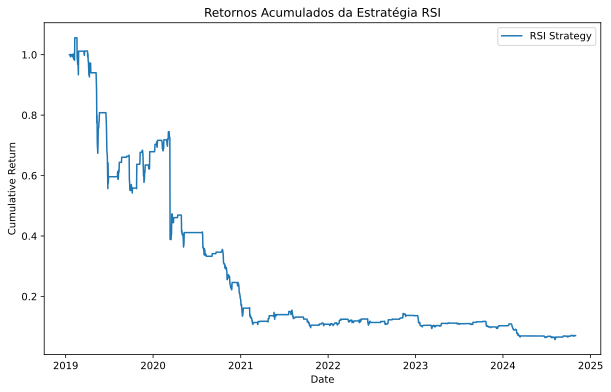

In [25]:
backtest_results = backtest_rsi(data)

plt.figure(figsize=(10, 6))
plt.plot(backtest_results.index, backtest_results['Cumulative Strategy Return'], label='RSI Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Retornos Acumulados da Estratégia RSI')
plt.legend()
plt.grid(False)
plt.show()


RSI com diferentes proporções

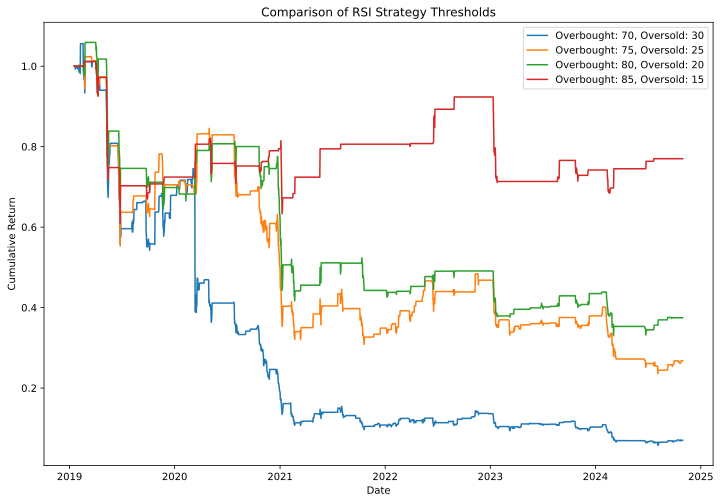

In [27]:
# Function to apply the RSI strategy with variable thresholds
def rsi_strategy_with_thresholds(data, overbought_threshold, oversold_threshold):
    data = data.copy()  # Create a copy to avoid modifying the original DataFrame
    data['Signal'] = 0  # Initialize signals
    data.loc[data['RSI'] < oversold_threshold, 'Signal'] = 1  # Buy signal
    data.loc[data['RSI'] > overbought_threshold, 'Signal'] = -1  # Sell signal
    return data

# Function to backtest the strategy
def backtest_rsi(data):
    df = data.copy()
    df['Position'] = df['Signal'].shift(1)  # Use the previous signal for position
    df['Strategy Return'] = df['Position'] * df['Returns']  # Calculate strategy returns
    df['Cumulative Strategy Return'] = (1 + df['Strategy Return']).cumprod()  # Cumulative returns
    return df

# Prepare data for backtesting
data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)


thresholds = [
    (70, 30),
    (75, 25),
    (80, 20),
    (85, 15),
]

# Guardar resultados nesse dicionário
results = {}

# Testar cada combinação
for overbought, oversold in thresholds:

    data_with_signals = rsi_strategy_with_thresholds(data, overbought, oversold)


    backtest_results = backtest_rsi(data_with_signals)


    results[f"Overbought: {overbought}, Oversold: {oversold}"] = backtest_results['Cumulative Strategy Return']

# Plot Comparativo
plt.figure(figsize=(12, 8))
for label, cumulative_return in results.items():
    plt.plot(cumulative_return.index, cumulative_return, label=label)

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Comparison of RSI Strategy Thresholds')
plt.legend()
plt.grid(False)
plt.show()


RSI 85/15 com diferentes períodos

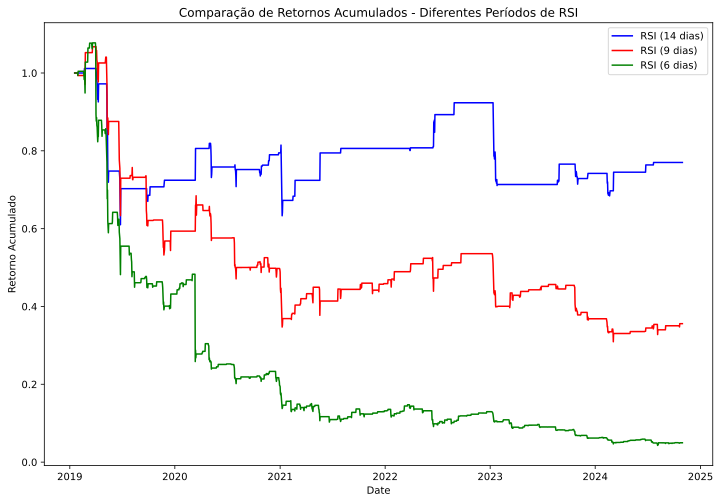

In [29]:
data['RSI_9'] = calculate_rsi(data['Close'], lookback=9)
data['RSI_6'] = calculate_rsi(data['Close'], lookback=6)


signals_rsi_9 = rsi_strategy_with_thresholds(data.assign(RSI=data['RSI_9']), overbought_threshold=85, oversold_threshold=15)
signals_rsi_6 = rsi_strategy_with_thresholds(data.assign(RSI=data['RSI_6']), overbought_threshold=85, oversold_threshold=15)

backtest_results_rsi_9 = backtest_rsi(data.assign(RSI=data['RSI_9'], Signal=signals_rsi_9['Signal']))
backtest_results_rsi_6 = backtest_rsi(data.assign(RSI=data['RSI_6'], Signal=signals_rsi_6['Signal']))




plt.figure(figsize=(12, 8))

plt.plot(backtest_results.index, backtest_results['Cumulative Strategy Return'], label='RSI (14 dias)', color='blue')
plt.plot(backtest_results_rsi_9.index, backtest_results_rsi_9['Cumulative Strategy Return'], label='RSI (9 dias)', color='red')
plt.plot(backtest_results_rsi_6.index, backtest_results_rsi_6['Cumulative Strategy Return'], label='RSI (6 dias)', color='green')
plt.title('Comparação de Retornos Acumulados - Diferentes Períodos de RSI')
plt.xlabel('Date')
plt.ylabel('Retorno Acumulado')
plt.legend()
plt.grid(False)
plt.show()

Combinando a melhor proporção com o EMA

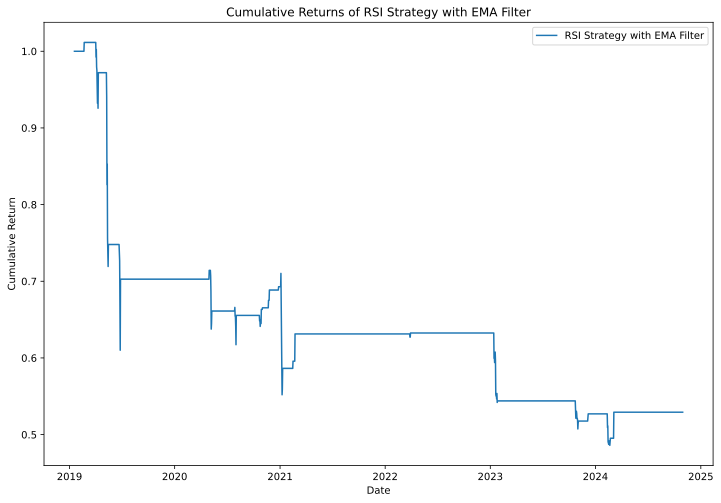

In [31]:
def rsi_strategy_with_ema(data, overbought_threshold=85, oversold_threshold=15):
    short_ema = data['Close'].ewm(span=20, adjust=False).mean()
    long_ema = data['Close'].ewm(span=50, adjust=False).mean()

    data = data.copy()
    data['Signal'] = 0

    data.loc[data['RSI'] < oversold_threshold, 'Signal'] = 1
    data.loc[data['RSI'] > overbought_threshold, 'Signal'] = -1

    data.loc[short_ema <= long_ema, 'Signal'] = 0

    return data


backtest_results_ema_rsi = backtest_rsi(rsi_strategy_with_ema(data))


plt.figure(figsize=(12, 8))
plt.plot(backtest_results_ema_rsi.index, backtest_results_ema_rsi['Cumulative Strategy Return'], label='RSI Strategy with EMA Filter')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns of RSI Strategy with EMA Filter')
plt.legend()
plt.grid(False)
plt.show()

RSI com Stop-Loss

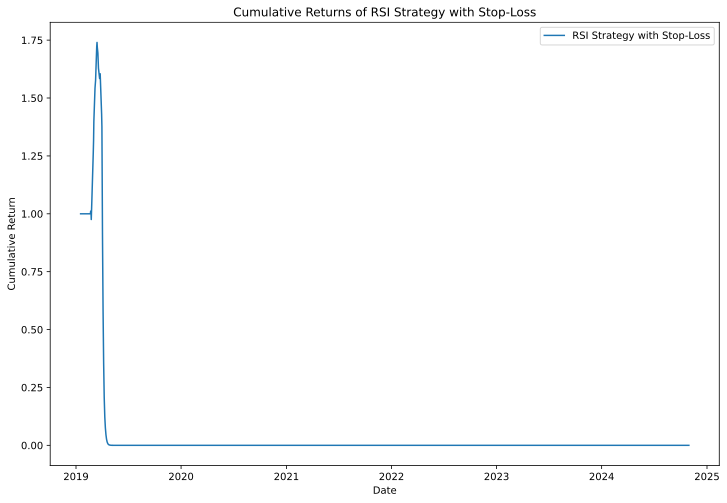

In [33]:
# Average True Range (ATR), para determinar o stop-loss de maneira dinâmica, por causa da volatilidade do BTC
def calculate_atr(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())

    true_range = pd.Series(np.maximum.reduce([high_low, high_close, low_close]))

    atr = true_range.rolling(window=window).mean()
    return atr


def rsi_strategy_with_stop_loss(data, overbought_threshold=85, oversold_threshold=15, atr_multiplier=2):
    data = data.copy()
    data['Signal'] = 0

    data.loc[data['RSI'] < oversold_threshold, 'Signal'] = 1
    data.loc[data['RSI'] > overbought_threshold, 'Signal'] = -1

    data['ATR'] = calculate_atr(data, window=14)

    position = 0
    entry_price = 0
    stop_loss = 0
    strategy_returns = []

    for i in range(len(data)):
        if position == 0:  # Hold
            if data['Signal'].iloc[i] == 1:
                position = 1
                entry_price = data['Close'].iloc[i]
                stop_loss = entry_price - atr_multiplier * data['ATR'].iloc[i]
            elif data['Signal'].iloc[i] == -1:
                position = -1
                entry_price = data['Close'].iloc[i]
                stop_loss = entry_price + atr_multiplier * data['ATR'].iloc[i]
            strategy_returns.append(0)
        else:  # Posições ativas
            if position == 1:  # Long
                if data['Close'].iloc[i] < stop_loss:
                    position = 0
                    strategy_returns.append(data['Close'].iloc[i] / entry_price - 1)
                else:
                    strategy_returns.append(data['Close'].iloc[i] / entry_price - 1)
            elif position == -1:  # Short
                if data['Close'].iloc[i] > stop_loss:
                    position = 0
                    strategy_returns.append(entry_price / data['Close'].iloc[i] - 1)
                else:
                    strategy_returns.append(entry_price / data['Close'].iloc[i] - 1)

    # Add strategy returns to the data
    data['Strategy Return'] = strategy_returns
    data['Cumulative Strategy Return'] = (1 + data['Strategy Return']).cumprod()

    return data

# Calculate RSI, ATR, and apply the strategy
data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['ATR'] = calculate_atr(data, window=14)
data = rsi_strategy_with_stop_loss(data)

plt.figure(figsize=(12, 8))
plt.plot(data.index, data['Cumulative Strategy Return'], label='RSI Strategy with Stop-Loss')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns of RSI Strategy with Stop-Loss')
plt.legend()
plt.grid(False)
plt.show()


Diferentes ATRs

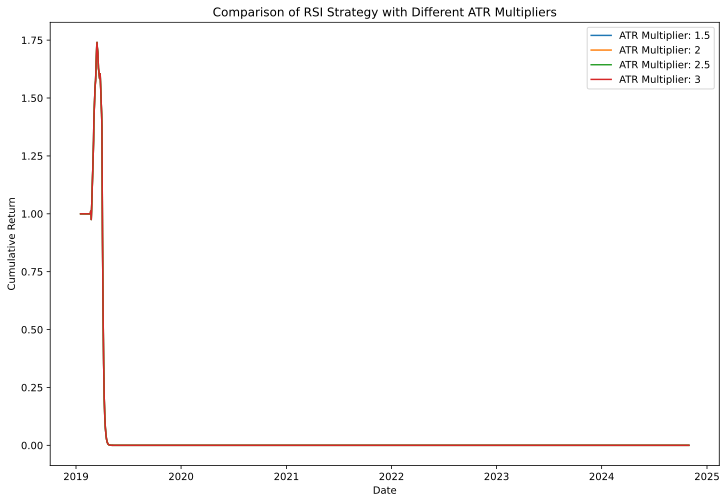

In [38]:
atr_multipliers = [1.5, 2, 2.5, 3]

results = {}

for multiplier in atr_multipliers:
    # Apply the strategy with the current atr_multiplier
    strategy_results = rsi_strategy_with_stop_loss(data, atr_multiplier=multiplier)

    # Store cumulative returns
    results[f"ATR Multiplier: {multiplier}"] = strategy_results['Cumulative Strategy Return']

# Plot results for comparison
plt.figure(figsize=(12, 8))
for label, cumulative_return in results.items():
    plt.plot(data.index, cumulative_return, label=label)

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Comparison of RSI Strategy with Different ATR Multipliers')
plt.legend()
plt.grid(False)
plt.show()


Portfolio com RSI 85/15

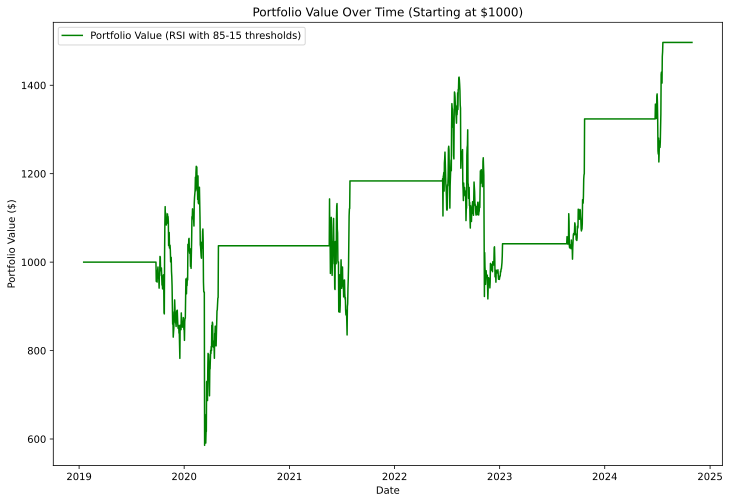

In [40]:
def calculate_portfolio_value(data, initial_portfolio=1000):
    """
    Calculate portfolio value over time based on RSI strategy.
    """
    portfolio_value = initial_portfolio
    position = 0  # Position: 1 for long, 0 for cash
    portfolio_values = []

    for i in range(len(data)):
        if position == 0:  # Currently in cash
            if data['Signal'].iloc[i] == 1:  # Buy signal
                position = portfolio_value / data['Close'].iloc[i]  # Buy BTC
            portfolio_values.append(portfolio_value)
        elif position > 0:  # Currently holding BTC
            if data['Signal'].iloc[i] == -1:  # Sell signal
                portfolio_value = position * data['Close'].iloc[i]  # Sell BTC
                position = 0  # Move to cash
            portfolio_values.append(portfolio_value if position == 0 else position * data['Close'].iloc[i])

    # Add portfolio values to the DataFrame
    data['Portfolio Value'] = portfolio_values
    return data


data['RSI'] = calculate_rsi(data['Close'], lookback=14)

# Geração de sinais com o RSI e thresholds 85-15
data = rsi_strategy_with_thresholds(data.assign(RSI=data['RSI']), overbought_threshold=85, oversold_threshold=15)

# Calcular valor do portfólio
data = calculate_portfolio_value(data)

# Plot do valor do portfólio
plt.figure(figsize=(12, 8))
plt.plot(data.index, data['Portfolio Value'], label='Portfolio Value (RSI with 85-15 thresholds)', color='green')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time (Starting at $1000)')
plt.legend()
plt.grid(False)
plt.show()


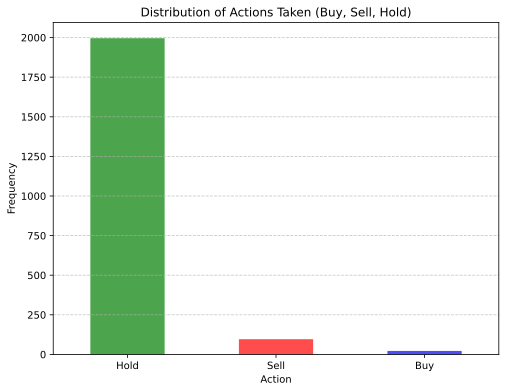

In [41]:
# Map actions for easier labeling
data['Action'] = data['Signal'].map({1: 'Buy', -1: 'Sell', 0: 'Hold'})

# Count the actions over the period
action_counts = data['Action'].value_counts()

# Plot bar plot for action counts
plt.figure(figsize=(8, 6))
action_counts.plot(kind='bar', color=['green', 'red', 'blue'], alpha=0.7)
plt.title('Distribution of Actions Taken (Buy, Sell, Hold)')
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


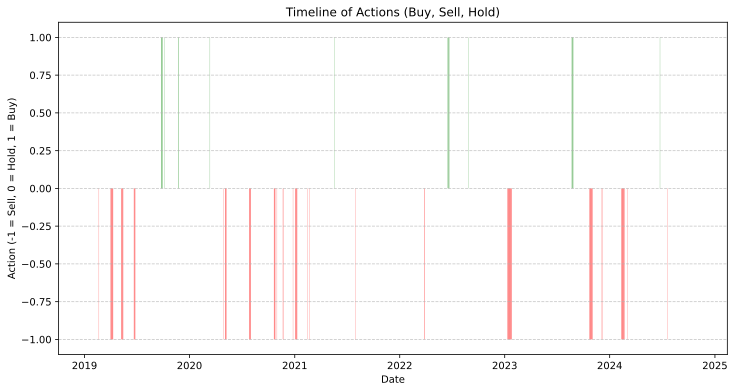

In [44]:
# Extract action dates and map colors for visualization
action_colors = {'Buy': 'green', 'Sell': 'red', 'Hold': 'blue'}

# Create a bar plot over time
plt.figure(figsize=(12, 6))
plt.bar(data.index, data['Signal'], color=data['Action'].map(action_colors), alpha=0.7)
plt.title('Timeline of Actions (Buy, Sell, Hold)')
plt.xlabel('Date')
plt.ylabel('Action (-1 = Sell, 0 = Hold, 1 = Buy)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Portfolio com métricas

Sharpe Ratio: 0.32
CAGR: 7.22%
Cumulative Returns: 49.68%
Variance: 0.000370
CVaR: nan


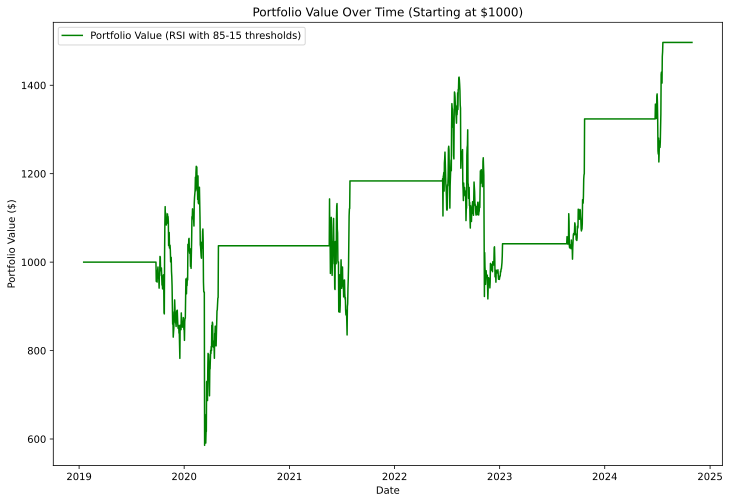

In [47]:
def calculate_metrics(data, initial_portfolio=1000):
    """
    Calculate key financial metrics: Sharpe Ratio, CAGR, Cumulative Returns, Variance, and CVaR.
    """
    # Retornos do portfólio
    data['Daily Returns'] = data['Portfolio Value'].pct_change().dropna()

    # Sharpe Ratio
    sharpe_ratio = data['Daily Returns'].mean() / data['Daily Returns'].std() * np.sqrt(252)

    # CAGR
    start_value = initial_portfolio
    end_value = data['Portfolio Value'].iloc[-1]
    num_years = (data.index[-1] - data.index[0]).days / 365.25
    cagr = (end_value / start_value) ** (1 / num_years) - 1

    # Retorno Acumulado
    cumulative_returns = (end_value - start_value) / start_value * 100

    # Variância
    variance = data['Daily Returns'].var()

    # CVaR (Conditional Value at Risk)
    confidence_level = 0.95
    var = np.percentile(data['Daily Returns'], (1 - confidence_level) * 100)  # Valor no Percentil 5%
    cvar = data['Daily Returns'][data['Daily Returns'] <= var].mean()

    return sharpe_ratio, cagr, cumulative_returns, variance, cvar

# Certifique-se de que o RSI_6 está calculado
data['RSI'] = calculate_rsi(data['Close'], lookback=14)

# Geração de sinais com o RSI_6 e thresholds 85-15
data = rsi_strategy_with_thresholds(data.assign(RSI=data['RSI']), overbought_threshold=85, oversold_threshold=15)

# Calcular valor do portfólio
data = calculate_portfolio_value(data)

# Calcular métricas financeiras
sharpe_ratio, cagr, cumulative_returns, variance, cvar = calculate_metrics(data)

# Exibir as métricas
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"CAGR: {cagr:.2%}")
print(f"Cumulative Returns: {cumulative_returns:.2f}%")
print(f"Variance: {variance:.6f}")
print(f"CVaR: {cvar:.6f}")

# Plot do valor do portfólio
plt.figure(figsize=(12, 8))
plt.plot(data.index, data['Portfolio Value'], label='Portfolio Value (RSI with 85-15 thresholds)', color='green')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time (Starting at $1000)')
plt.legend()
plt.grid(False)
plt.show()


# **Multi-Arm Bandit Approaches**

# Epsilon-greedy

In [52]:
# Initializing the data once again
data = BTC_USD.history(start="2019-01-01", end="2024-10-31")

# Calculate EMA 50 and EMA 200
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()

In [53]:
class MAB_implementation:
    def __init__(self, data, initial_portfolio_value=10000, risk_free_rate=0.02):
        self.data = data
        self.initial_portfolio_value = initial_portfolio_value
        self.rf = (1 + risk_free_rate) ** (1 / 365) - 1  # Daily risk-free rate
        self.n_actions = 3  # Actions: [Hold, Buy, Sell]
        #self.d_rewards = pd.DataFrame()  # To store rewards for plotting
        #self.d_portfolio = pd.DataFrame()  # To store portfolio values for plotting

    def init_Q(self):
        """Initialize Q-values for each action."""
        return np.zeros(self.n_actions)

    def init_ucb(self):
        """Initialize counts and rewards for UCB."""
        return np.zeros(self.n_actions), np.zeros(self.n_actions)

    def select_action_eps_greedy(self, Q, epsilon):
        """Epsilon-greedy policy for action selection."""
        if np.random.rand() < epsilon:  # Explore: Random action
            return np.random.choice(len(Q))
        else:  # Exploit: Best-known action
            return np.argmax(Q)

    def select_action_ucb(self, Q, N, t):
        """
        UCB policy for action selection.

        Args:
            Q (np.array): Average rewards for each action.
            N (np.array): Number of times each action has been selected.
            t (int): Current time step.

        Returns:
            int: Selected action index.
        """
        if t < self.n_actions:  # Ensure each action is tried at least once
            return t
        ucb_values = Q + np.sqrt(2 * np.log(t + 1) / (N + 1e-5))  # Add small value to avoid division by zero
        return np.argmax(ucb_values)

    def calculate_reward(self, action, current_price, next_price):
        """Calculate reward based on the selected action."""
        daily_return = np.log(next_price / current_price)
        excess_return = daily_return - self.rf

        if action == 1:  # Buy BTC
            return excess_return
        elif action == 2:  # Sell BTC
            return -excess_return
        else:  # Hold BTC or cash (no trade)
            return 0

    def update_Q(self, Q, action, reward, learning_rate):
        """Update Q-values using the learning rate."""
        Q[action] += learning_rate * (reward - Q[action])
        return Q

    def calculate_discounted_rewards_per_step(self, rewards, discount_factor):
        """
        Calculate cumulative discounted rewards at each step.

        Args:
            rewards (list): List of rewards from a single run.
            discount_factor (float): Discount factor (0 < discount_factor <= 1).

        Returns:
            list: Cumulative discounted rewards at each step.
        """
        discounted_rewards = []
        cumulative_discounted_reward = 0
        for t, reward in enumerate(rewards):
            cumulative_discounted_reward += (discount_factor ** t) * reward
            discounted_rewards.append(cumulative_discounted_reward)
        return discounted_rewards


    def run_epsilon_greedy(self, epsilons, epsilon_decay_rate, learning_rate, n_runs, discount_factor):
      """
      Run the MAB-epsilon greedy simulation with EMA crossover signals and epsilon decay,
      evaluate performance, and display metrics in a table along with plots.

      Args:
          epsilons (list): Initial exploration rates to test.
          epsilon_decay_rate (float): Exponential decay rate for epsilon.
          learning_rate (float): Learning rate for Q-value updates.
          n_runs (int): Number of runs for averaging.
          discount_factor (float): Discount factor for calculating discounted rewards.

      Returns:
          None
      """
      # Dataframes to store results
      portfolio_aux_df = pd.DataFrame()  # For portfolio values
      rewards_aux_df = pd.DataFrame()  # For average rewards
      discounted_rewards_aux_df = pd.DataFrame()  # For discounted rewards
      results = []  # To store metrics for each epsilon

      for epsilon in tqdm(epsilons):
          print(f"Running simulation for Epsilon: {epsilon} with decay rate: {epsilon_decay_rate}")

          # Reset random seed for reproducibility per epsilon
          np.random.seed(42)
          random.seed(42)

          portfolio_runs = []
          rewards_runs = []
          discounted_rewards_runs = []

          for run in range(n_runs):
              rewards = []
              portfolio_values = [self.initial_portfolio_value]
              Q = self.init_Q()  # Initialize Q-values for each run

              portfolio_value = self.initial_portfolio_value
              btc_holdings = 0
              current_epsilon = epsilon  # Initialize epsilon for this run

              # Initialize previous state of EMA comparison
              prev_ema_state = None  # None means no previous state yet

              for t in range(len(self.data) - 1):  # Loop through trading days
                  current_price = self.data['Close'].iloc[t]
                  next_price = self.data['Close'].iloc[t + 1]

                  # Use precomputed EMA values for crossover signals
                  ema_50 = self.data['EMA_50'].iloc[t]
                  ema_200 = self.data['EMA_200'].iloc[t]

                  # Determine current EMA state: 'above' or 'below'
                  if ema_50 > ema_200:
                      current_ema_state = "above"
                  elif ema_50 < ema_200:
                      current_ema_state = "below"
                  else:
                      current_ema_state = "neutral"

                  # Decision logic: prioritize EMA signals only on crossover days
                  if prev_ema_state == "below" and current_ema_state == "above":  # Golden Cross: Buy Signal
                      action = 1  # Buy
                  elif prev_ema_state == "above" and current_ema_state == "below":  # Death Cross: Sell Signal
                      action = 2  # Sell
                  else:
                      # Use epsilon-greedy policy if no crossover signal
                      action = self.select_action_eps_greedy(Q, current_epsilon)

                  # Update previous EMA state
                  prev_ema_state = current_ema_state

                  # Calculate reward based on the action and price movement
                  reward = self.calculate_reward(action, current_price, next_price)

                  # Update Q-values using learning rate
                  Q = self.update_Q(Q, action, reward, learning_rate)

                  # Update portfolio value based on the action taken
                  if action == 1 and portfolio_value > current_price:  # Buy BTC with all available cash
                      btc_holdings += portfolio_value / current_price
                      portfolio_value = 0

                  elif action == 2 and btc_holdings > 0:  # Sell BTC holdings for cash
                      portfolio_value += btc_holdings * current_price
                      btc_holdings = 0

                  # Portfolio value after this step (including any BTC holdings)
                  total_portfolio_value = portfolio_value + btc_holdings * next_price
                  portfolio_values.append(total_portfolio_value)
                  rewards.append(reward)

                  # Apply exponential decay to epsilon after each step
                  current_epsilon *= epsilon_decay_rate

              # Calculate cumulative discounted rewards per step for this run
              discounted_rewards_per_step = self.calculate_discounted_rewards_per_step(rewards, discount_factor)
              discounted_rewards_runs.append(discounted_rewards_per_step)

              # Store portfolio values and rewards for this run
              portfolio_runs.append(portfolio_values)
              rewards_runs.append(rewards)

          # Average metrics across runs at each step
          avg_portfolio_values = np.array(portfolio_runs).mean(axis=0)
          avg_rewards = np.array(rewards_runs).mean(axis=0)
          avg_discounted_rewards_per_step = np.array(discounted_rewards_runs).mean(axis=0)

          # Add average metrics to auxiliary dataframes
          portfolio_aux_df[f"Epsilon {epsilon}"] = avg_portfolio_values
          rewards_aux_df[f"Epsilon {epsilon}"] = avg_rewards
          discounted_rewards_aux_df[f"Epsilon {epsilon}"] = avg_discounted_rewards_per_step

          # Calculate financial metrics:
          final_portfolio_value = avg_portfolio_values[-1]
          daily_returns = np.diff(avg_portfolio_values) / avg_portfolio_values[:-1]

          sharpe_ratio = (np.mean(daily_returns) - self.rf) / np.std(daily_returns) * np.sqrt(365)
          cagr = ((final_portfolio_value / self.initial_portfolio_value) ** (1 / (len(self.data) / 365))) - 1
          cumulative_returns = (final_portfolio_value - self.initial_portfolio_value) / self.initial_portfolio_value

          variance = np.var(daily_returns)
          cvar_threshold = np.percentile(daily_returns, 5)
          cvar = daily_returns[daily_returns <= cvar_threshold].mean()

          results.append({
              'Epsilon': epsilon,
              'Sharpe Ratio': sharpe_ratio,
              'CAGR': cagr,
              'Cumulative Returns': cumulative_returns,
              'Variance': variance,
              'CVaR': cvar,
              'Final Portfolio Value': final_portfolio_value,
              'Discounted Reward': avg_discounted_rewards_per_step[-1] if len(avg_discounted_rewards_per_step) > 0 else None,
          })

      # Convert results to a DataFrame and display it fully in Google Colab or Jupyter Notebook
      results_df = pd.DataFrame(results).sort_values(by='Sharpe Ratio', ascending=False)
      print("\nFinal Results:")
      display(results_df)  # Display full table without truncation

      # Plotting the average portfolio value over time using the auxiliary dataframe
      plt.figure(figsize=(10, 6))
      for column in portfolio_aux_df.columns:
          sns.lineplot(data=portfolio_aux_df[column], label=column)
      plt.title('Portfolio Value Over Time (epsilon-greedy)')
      plt.xlabel('Step (Trading Day)')
      plt.ylabel('Portfolio Value (USD)')
      plt.legend()
      plt.show()

      # Plotting the average rewards over time using the auxiliary dataframe
      plt.figure(figsize=(10, 6))
      for column in rewards_aux_df.columns:
          sns.lineplot(data=rewards_aux_df[column], label=column)
      plt.title('Average Reward Over Time (epsilon-greedy)')
      plt.xlabel('Step (Trading Day)')
      plt.ylabel('Average Reward')
      plt.legend()
      plt.show()

      # Plotting the average cumulative discounted rewards over time using the auxiliary dataframe
      plt.figure(figsize=(10, 6))
      for column in discounted_rewards_aux_df.columns:
          sns.lineplot(data=discounted_rewards_aux_df[column], label=column)
      plt.title('Cumulative Discounted Rewards Over Time (epsilon-greedy)')
      plt.xlabel('Step (Trading Day)')
      plt.ylabel('Cumulative Discounted Reward')
      plt.legend()
      plt.show()


    def run_ucb(self, c_values, n_runs=100, gamma=0.95):
      """
      Run the UCB simulation for different exploration factors (c), evaluate their performance,
      and display metrics in a table along with plots.

      Args:
          c_values (list): List of exploration factors to test.
          n_runs (int): Number of runs for averaging.
          gamma (float): Discount factor for calculating discounted rewards.

      Returns:
          pd.DataFrame: Results with financial metrics for each exploration factor.
      """
      # Dataframes to store results
      portfolio_aux_df = pd.DataFrame()  # For portfolio values
      rewards_aux_df = pd.DataFrame()   # For average rewards
      discounted_rewards_aux_df = pd.DataFrame()  # For discounted rewards

      results = []  # To store metrics for each exploration factor

      for c in tqdm(c_values):
          print(f"Running simulation for Exploration Factor c: {c}")

          # Reset random seed for reproducibility per epsilon
          np.random.seed(42)
          random.seed(42)
          
          portfolio_runs = []
          rewards_runs = []
          discounted_rewards_runs = []

          for run in range(n_runs):
              rewards = []
              portfolio_values = [self.initial_portfolio_value]
              Q, N = self.init_ucb()  # Initialize Q-values and counts for UCB
              portfolio_value = self.initial_portfolio_value
              btc_holdings = 0

              for t in range(len(self.data) - 1):
                  current_price = self.data['Close'].iloc[t]
                  next_price = self.data['Close'].iloc[t + 1]

                  # Select an action using UCB policy with scaling factor c
                  ucb_values = Q + c * np.sqrt(2 * np.log(t + 1) / (N + 1e-5))
                  action = np.argmax(ucb_values)

                  # Calculate reward based on the action and price movement
                  reward = self.calculate_reward(action, current_price, next_price)

                  # Update Q-values and counts
                  N[action] += 1
                  Q[action] += (reward - Q[action]) / N[action]

                  # Update portfolio value based on the action taken
                  if action == 1 and portfolio_value > current_price:  # Buy BTC with all available cash
                      btc_holdings += portfolio_value / current_price
                      portfolio_value = 0

                  elif action == 2 and btc_holdings > 0:  # Sell BTC holdings for cash
                      portfolio_value += btc_holdings * current_price
                      btc_holdings = 0

                  # Portfolio value after this step (including any BTC holdings)
                  total_portfolio_value = portfolio_value + btc_holdings * next_price
                  portfolio_values.append(total_portfolio_value)
                  rewards.append(reward)

              # Calculate cumulative discounted rewards per step for this run
              discounted_rewards_per_step = self.calculate_discounted_rewards_per_step(rewards, gamma)

              # Store portfolio values and rewards for this run
              portfolio_runs.append(portfolio_values)
              rewards_runs.append(rewards)
              discounted_rewards_runs.append(discounted_rewards_per_step)

          # Average metrics across runs for this exploration factor at each step
          avg_portfolio_values = np.array(portfolio_runs).mean(axis=0)
          avg_rewards = np.array(rewards_runs).mean(axis=0)
          avg_discounted_rewards_per_step = np.array(discounted_rewards_runs).mean(axis=0)

          # Add average metrics to auxiliary dataframes
          portfolio_aux_df[f"c={c}"] = avg_portfolio_values
          rewards_aux_df[f"c={c}"] = avg_rewards
          discounted_rewards_aux_df[f"c={c}"] = avg_discounted_rewards_per_step

          # Calculate financial metrics:
          final_portfolio_value = avg_portfolio_values[-1]
          daily_returns = np.diff(avg_portfolio_values) / avg_portfolio_values[:-1]

          sharpe_ratio = (np.mean(daily_returns) - self.rf) / np.std(daily_returns) * np.sqrt(365)
          cagr = ((final_portfolio_value / self.initial_portfolio_value) ** (1 / (len(self.data) / 365))) - 1
          cumulative_returns = (final_portfolio_value - self.initial_portfolio_value) / self.initial_portfolio_value

          variance = np.var(daily_returns)
          cvar_threshold = np.percentile(daily_returns, 5)
          cvar = daily_returns[daily_returns <= cvar_threshold].mean()

          results.append({
              'Exploration Factor': c,
              'Sharpe Ratio': sharpe_ratio,
              'CAGR': cagr,
              'Cumulative Returns': cumulative_returns,
              'Variance': variance,
              'CVaR': cvar,
              'Final Portfolio Value': final_portfolio_value,
              'Discounted Reward': avg_discounted_rewards_per_step[-1] if len(avg_discounted_rewards_per_step) > 0 else None,
          })

      # Convert results to a DataFrame and display it fully in Google Colab or Jupyter Notebook
      results_df = pd.DataFrame(results).sort_values(by='Sharpe Ratio', ascending=False)
      print("\nFinal Results:")
      display(results_df)

      # Plotting the average portfolio value over time using the auxiliary dataframe
      plt.figure(figsize=(10, 6))
      for column in portfolio_aux_df.columns:
          sns.lineplot(data=portfolio_aux_df[column], label=column)
      plt.title('Portfolio Value Over Time (UCB)')
      plt.xlabel('Step (Trading Day)')
      plt.ylabel('Portfolio Value (USD)')
      plt.legend()
      plt.show()

      # Plotting the average rewards over time using the auxiliary dataframe
      plt.figure(figsize=(10, 6))
      for column in rewards_aux_df.columns:
          sns.lineplot(data=rewards_aux_df[column], label=column)
      plt.title('Average Reward Over Time (UCB)')
      plt.xlabel('Step (Trading Day)')
      plt.ylabel('Average Reward')
      plt.legend()
      plt.show()

      # Plotting the average cumulative discounted rewards over time using the auxiliary dataframe
      plt.figure(figsize=(10, 6))
      for column in discounted_rewards_aux_df.columns:
          sns.lineplot(data=discounted_rewards_aux_df[column], label=column)
      plt.title('Cumulative Discounted Rewards Over Time (UCB)')
      plt.xlabel('Step (Trading Day)')
      plt.ylabel('Cumulative Discounted Reward')
      plt.legend()
      plt.show()

In [56]:
# Initialization of the class
mab_model = MAB_implementation(data)

# Defining the parameters for running simulations:
epsilons = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Exploration rates to test
epsilon_decay_rate = 0.999
learning_rate = 0.05         # Learning rate for Q-value updates
n_runs = 500                  # Number of runs to average results

Epsilon-greedy with decay rate, and EMA 50/200

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Running simulation for Epsilon: 0.3 with decay rate: 0.999


 14%|████████████                                                                        | 1/7 [01:32<09:13, 92.19s/it]

Running simulation for Epsilon: 0.4 with decay rate: 0.999


 29%|████████████████████████                                                            | 2/7 [03:04<07:41, 92.35s/it]

Running simulation for Epsilon: 0.5 with decay rate: 0.999


 43%|████████████████████████████████████                                                | 3/7 [04:40<06:15, 93.88s/it]

Running simulation for Epsilon: 0.6 with decay rate: 0.999


 57%|████████████████████████████████████████████████                                    | 4/7 [06:14<04:42, 94.14s/it]

Running simulation for Epsilon: 0.7 with decay rate: 0.999


 71%|████████████████████████████████████████████████████████████                        | 5/7 [07:54<03:12, 96.24s/it]

Running simulation for Epsilon: 0.8 with decay rate: 0.999


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [09:33<01:37, 97.18s/it]

Running simulation for Epsilon: 0.9 with decay rate: 0.999


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [11:13<00:00, 96.26s/it]


Final Results:


Epsilon  Sharpe Ratio      CAGR  Cumulative Returns  Variance      CVaR  \
5      0.8      1.217731  0.447005            7.638574  0.000304 -0.038583   
6      0.9      1.190521  0.430464            7.078010  0.000298 -0.038450   
2      0.5      1.184623  0.441572            7.450984  0.000320 -0.039642   
3      0.6      1.180218  0.435688            7.251682  0.000314 -0.039605   
4      0.7      1.179214  0.427817            6.991142  0.000303 -0.039143   
1      0.4      1.178803  0.431012            7.096064  0.000308 -0.039082   
0      0.3      1.159206  0.419581            6.725896  0.000305 -0.039170   

   Final Portfolio Value  Discounted Reward  
5           86385.743919           0.013466  
6           80780.098707           0.001175  
2           84509.837689           0.040094  
3           82516.820661           0.022280  
4           79911.417495          -0.007889  
1           80960.643799           0.023546  
0           77258.961648           0.025315

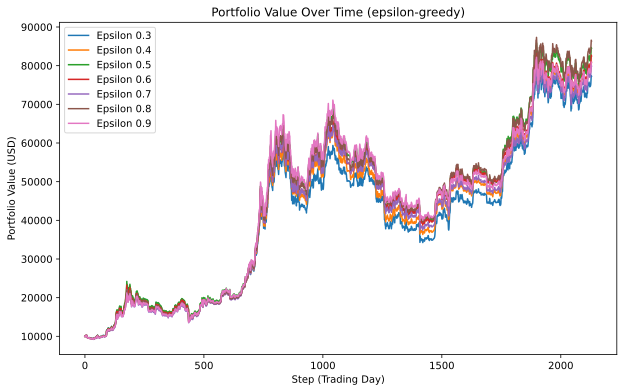

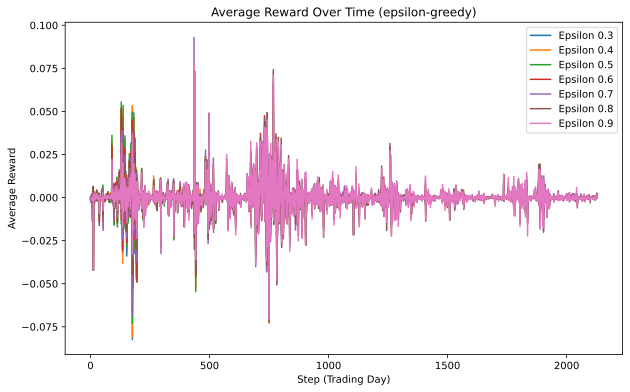

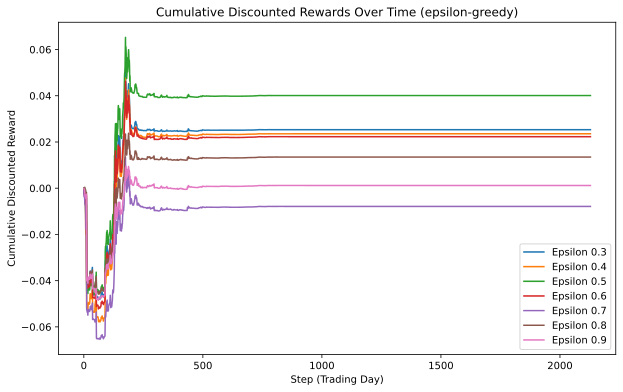

In [66]:
# Discount factor applied to rewards
discount_factor = 0.99
mab_model.run_epsilon_greedy(epsilons, epsilon_decay_rate, learning_rate, n_runs, discount_factor)

# Upper Confidence Bound

In [68]:
# Define a list of exploration factors to test
c_values = [0.8, 0.9, 1.0, 1.1, 1.2]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Running simulation for Exploration Factor c: 0.8


 20%|████████████████▊                                                                   | 1/5 [01:09<04:37, 69.45s/it]

Running simulation for Exploration Factor c: 0.9


 40%|█████████████████████████████████▌                                                  | 2/5 [02:17<03:25, 68.59s/it]

Running simulation for Exploration Factor c: 1.0


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:30<02:21, 70.63s/it]

Running simulation for Exploration Factor c: 1.1


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:45<01:12, 72.51s/it]

Running simulation for Exploration Factor c: 1.2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:59<00:00, 71.92s/it]


Final Results:


Exploration Factor  Sharpe Ratio      CAGR  Cumulative Returns  Variance  \
0                 0.8      1.256681  0.595481           14.275577  0.000503   
1                 0.9      1.202448  0.462492            8.192250  0.000337   
3                 1.1      1.084816  0.471611            8.531809  0.000479   
4                 1.2      0.368376  0.084708            0.607207  0.000176   
2                 1.0      0.327141  0.074273            0.519051  0.000188   

       CVaR  Final Portfolio Value  Discounted Reward  
0 -0.051797          152755.769161          -0.049371  
1 -0.042031           91922.495934           0.050205  
3 -0.053313           95318.089438          -0.027300  
4 -0.030091           16072.068824           0.054113  
2 -0.031305           15190.507186          -0.059583

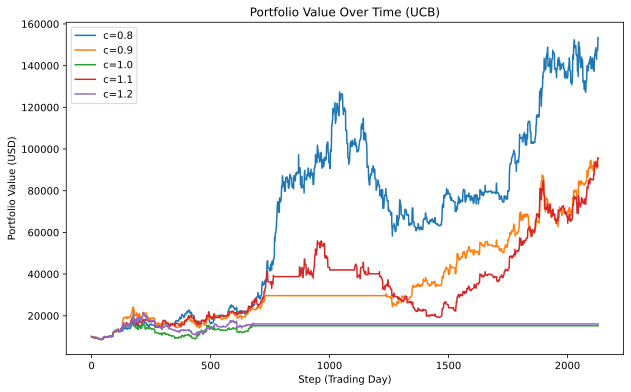

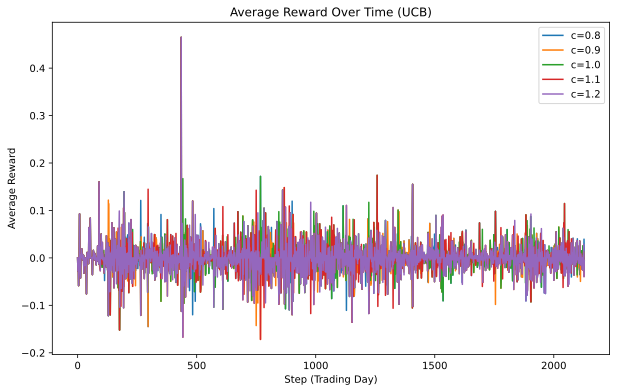

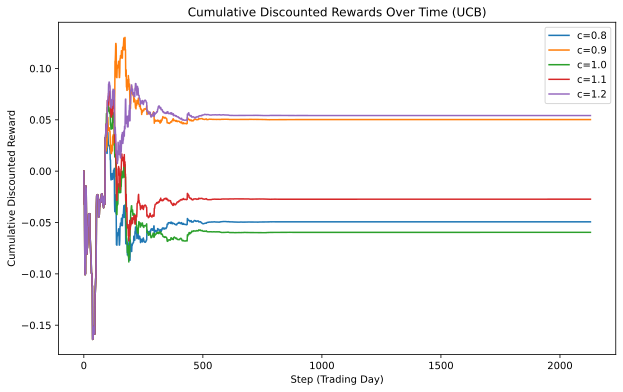

In [69]:
# Run UCB simulation with different exploration factors
mab_model.run_ucb(c_values=c_values, n_runs=500, gamma=0.99)

## Thompson Sampling

In [54]:
# Thompson Sampling
# Fetch BTC-USD data
BTC_USD = yf.Ticker("BTC-USD")
data = BTC_USD.history(start="2019-01-01", end="2024-10-31")

# Calculate daily returns
data['Returns'] = data['Close'].pct_change()
data = data.dropna()

class ThompsonSampling():
    def __init__(self):
        self.counts = []
        self.values = []
        self.a = []
        self.b = []

    def initialize(self, n_arms, alpha_prior=1, beta_prior=1):
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
        self.a = [alpha_prior] * n_arms
        self.b = [beta_prior] * n_arms


    def select_arm(self):
        beta_samples = [beta.rvs(a, b) for a, b in zip(self.a, self.b)]
        return np.argmax(beta_samples)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        # Update average reward
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

        # Update beta parameters
        self.a[chosen_arm] += reward
        self.b[chosen_arm] += (1 - reward)

# Function to evaluate a configuration
def evaluate_config(short_span, long_span, alpha_prior, beta_prior):
    # Calculate EMAs based on spans
    short_ema = data['Close'].ewm(span=short_span, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_span, adjust=False).mean()

    # Define reward based on EMA crossover: Reward is 1 if short EMA > long EMA, else 0
    data['Reward'] = (short_ema > long_ema).astype(int)

    # Initialize Thompson Sampling algorithm with three arms
    n_arms = 3  # Define number of arms
    algo = ThompsonSampling()
    algo.initialize(n_arms=n_arms, alpha_prior=alpha_prior, beta_prior=beta_prior)

    # Simulate rounds of interaction with arms using EMA-based rewards
    num_rounds = len(data)
    rewards = []
    for i in range(num_rounds):
        chosen_arm = algo.select_arm()
        reward = data['Reward'].iloc[i]
        algo.update(chosen_arm, reward)
        rewards.append(reward)

    # Calculate cumulative rewards over time and Sharpe Ratio as performance metrics
    cumulative_rewards_array = np.cumsum(rewards)
    sharpe_ratio = (np.mean(rewards) - 0.03 / 365) / np.std(rewards) if np.std(rewards) > 0 else 0

    return cumulative_rewards_array[-1], sharpe_ratio

# Hyperparameter grid for tuning
short_spans = [5, 10, 20, 30, 40, 50]
long_spans = [50, 100, 150, 200]
alpha_priors = [1, 2]
beta_priors = [1, 2]

# Grid search over all combinations of hyperparameters
best_config = None
best_cumulative_reward = -np.inf

for short_span, long_span, alpha_prior, beta_prior in product(short_spans, long_spans, alpha_priors, beta_priors):
    cumulative_reward, sharpe_ratio = evaluate_config(short_span, long_span, alpha_prior, beta_prior)

    print(f"Config: Short EMA={short_span}, Long EMA={long_span}, Alpha={alpha_prior}, Beta={beta_prior}")
    print(f"Cumulative Reward: {cumulative_reward:.2f}, Sharpe Ratio: {sharpe_ratio:.2f}")

    if cumulative_reward > best_cumulative_reward:
        best_cumulative_reward = cumulative_reward
        best_config = (short_span, long_span, alpha_prior, beta_prior)

# Print the best configuration and its performance
print("\nBest Configuration:")
print(f"Short EMA={best_config[0]}, Long EMA={best_config[1]}, Alpha={best_config[2]}, Beta={best_config[3]}")
print(f"Best Cumulative Reward: {best_cumulative_reward:.2f}")

Config: Short EMA=5, Long EMA=50, Alpha=1, Beta=1
Cumulative Reward: 1194.00, Sharpe Ratio: 1.13
Config: Short EMA=5, Long EMA=50, Alpha=1, Beta=2
Cumulative Reward: 1194.00, Sharpe Ratio: 1.13
Config: Short EMA=5, Long EMA=50, Alpha=2, Beta=1
Cumulative Reward: 1194.00, Sharpe Ratio: 1.13
Config: Short EMA=5, Long EMA=50, Alpha=2, Beta=2
Cumulative Reward: 1194.00, Sharpe Ratio: 1.13
Config: Short EMA=5, Long EMA=100, Alpha=1, Beta=1
Cumulative Reward: 1321.00, Sharpe Ratio: 1.28
Config: Short EMA=5, Long EMA=100, Alpha=1, Beta=2
Cumulative Reward: 1321.00, Sharpe Ratio: 1.28
Config: Short EMA=5, Long EMA=100, Alpha=2, Beta=1
Cumulative Reward: 1321.00, Sharpe Ratio: 1.28
Config: Short EMA=5, Long EMA=100, Alpha=2, Beta=2
Cumulative Reward: 1321.00, Sharpe Ratio: 1.28
Config: Short EMA=5, Long EMA=150, Alpha=1, Beta=1
Cumulative Reward: 1360.00, Sharpe Ratio: 1.33
Config: Short EMA=5, Long EMA=150, Alpha=1, Beta=2
Cumulative Reward: 1360.00, Sharpe Ratio: 1.33
Config: Short EMA=5, Lon

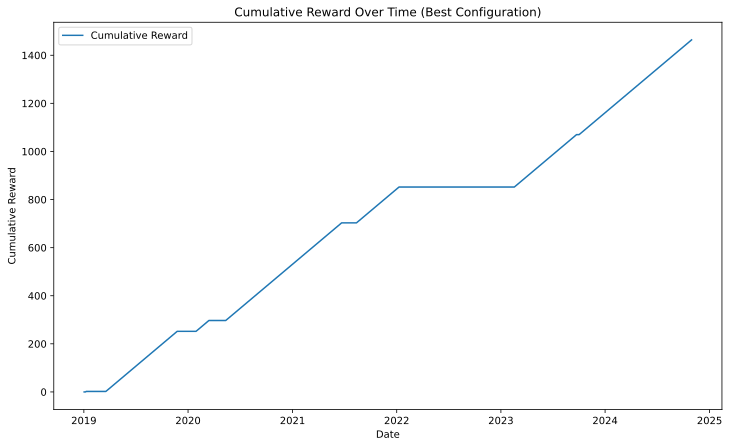

Sharpe Ratio: 1.48
CAGR: 248.95%
Cumulative Returns: 146400.00%
Variance: 78.397870
CVaR: 0.000000


In [55]:
# Use the best configuration for final simulation
short_ema_best = data['Close'].ewm(span=best_config[0], adjust=False).mean()
long_ema_best = data['Close'].ewm(span=best_config[1], adjust=False).mean()
data['Reward'] = (short_ema_best > long_ema_best).astype(int)

algo = ThompsonSampling()
algo.initialize(3, best_config[2], best_config[3])

rewards_final = []
for i in range(len(data)):
    chosen_arm_final = algo.select_arm()
    reward_final = data['Reward'].iloc[i]
    algo.update(chosen_arm_final, reward_final)
    rewards_final.append(reward_final)

cumulative_rewards_array_final = np.cumsum(rewards_final)
data['Cumulative Reward'] = cumulative_rewards_array_final

# Plot results: Cumulative Reward vs Dates for best configuration
plt.figure(figsize=(12, 7))
plt.plot(data.index, data['Cumulative Reward'], label="Cumulative Reward")
plt.xlabel('Date')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Over Time (Best Configuration)')
plt.legend()
plt.show()

# Calculate performance metrics: Sharpe Ratio and CAGR (Compound Annual Growth Rate)
risk_free_rate_daily = 0.03 / 365  # Adjust risk-free rate for 365 days

# Sharpe Ratio: Adjusted for daily returns over 365 days
sharpe_ratio_final = (np.mean(rewards_final) - risk_free_rate_daily) / np.std(rewards_final) if np.std(rewards_final) > 0 else 0

# CAGR: Adjusted for 365 days based on total cumulative reward
cagr_final = (cumulative_rewards_array_final[-1] + 1) ** (365 / len(data)) - 1

# Variance: Annualized variance of rewards
variance_final = np.var(rewards_final) * 365

# CVaR: Conditional Value at Risk (5th percentile), annualized
rewards_array = np.array(rewards_final)  # Ensure rewards_final is a NumPy array
percentile_5 = np.percentile(rewards_array, 5)
filtered_rewards = rewards_array[rewards_array <= percentile_5]
cvar_final = filtered_rewards.mean() * 365 if len(filtered_rewards) > 0 else 0

# Print metrics
print(f"Sharpe Ratio: {sharpe_ratio_final:.2f}")
print(f"CAGR: {cagr_final:.2%}")
print(f"Cumulative Returns: {cumulative_rewards_array_final[-1]:.2%}")
print(f"Variance: {variance_final:.6f}")
print(f"CVaR: {cvar_final:.6f}")



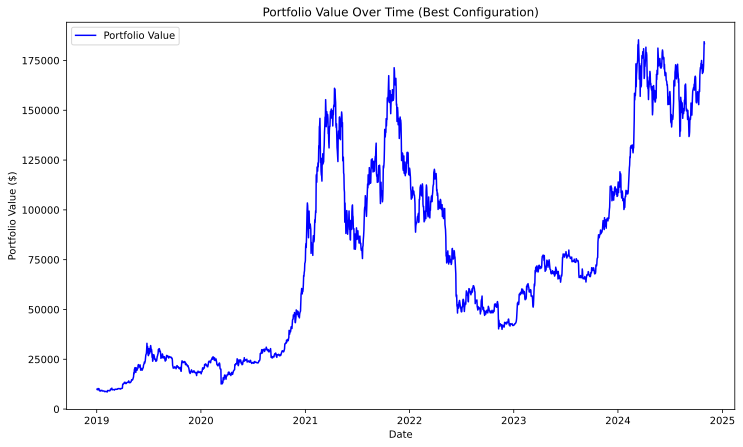

In [56]:
# Calculate daily percentage returns
data['Daily Return'] = data['Close'].pct_change() * 100

# Replace rewards_final with daily returns
rewards_final = data['Daily Return'].fillna(0).tolist()

# Initialize Portfolio Value column
initial_capital = 10000
portfolio_values = [initial_capital]

# Calculate portfolio value iteratively based on realistic returns
for reward in rewards_final:
    new_value = portfolio_values[-1] * (1 + reward / 100)
    portfolio_values.append(new_value)

# Add Portfolio Value to DataFrame (skip initial capital row if necessary)
data['Portfolio Value'] = portfolio_values[1:]

# Plot results: Portfolio Value vs Dates for best configuration
plt.figure(figsize=(12, 7))
plt.plot(data.index, data['Portfolio Value'], label="Portfolio Value", color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time (Best Configuration)')
plt.legend()
plt.grid(False)
plt.show()


Best arm is 3
Simulation complete.


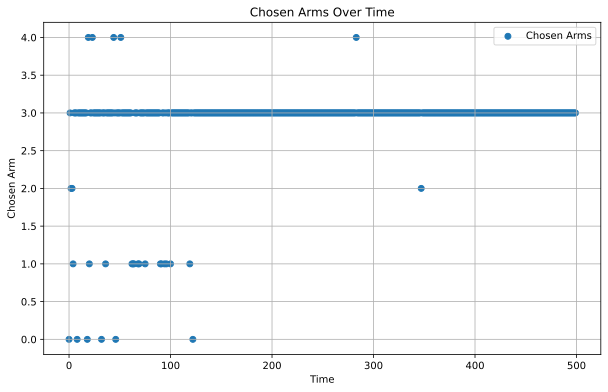

In [57]:
# Define BernoulliArm class
class BernoulliArm:
    def __init__(self, p):
        self.p = p  # Probability of reward

    def draw(self):
        return 1 if random.random() < self.p else 0

# Define test_algorithm function
def test_algorithm(algo, arms, num_sims, horizon):
    sim_nums = []
    times = []
    chosen_arms = []
    rewards = []
    cumulative_rewards = []

    for sim in range(num_sims):
        algo.initialize(len(arms))  # Reset algorithm for each simulation
        cumulative_reward = 0

        for t in range(horizon):
            chosen_arm = algo.select_arm()
            reward = arms[chosen_arm].draw()
            algo.update(chosen_arm, reward)

            # Log results
            sim_nums.append(sim)
            times.append(t)
            chosen_arms.append(chosen_arm)
            rewards.append(reward)
            cumulative_reward += reward
            cumulative_rewards.append(cumulative_reward)

    return sim_nums, times, chosen_arms, rewards, cumulative_rewards

# Additional code to simulate Thompson Sampling with Bernoulli Arms
random.seed(42)
n_arms = 5
segment_size = len(data) // n_arms

means = []
for i in range(n_arms):
    segment_rewards = data['Reward'].iloc[i * segment_size:(i + 1) * segment_size]
    means.append(segment_rewards.mean())

# Shuffling arms to simulate unknown best arm
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

# Create simulations for ThompsonSampling
algo = ThompsonSampling()
algo.initialize(n_arms)
results = test_algorithm(algo, arms, num_sims=500, horizon=500)

print("Simulation complete.")

# Extract results from simulation
sim_nums, times, chosen_arms, rewards, cumulative_rewards = results

# Convert results to numpy arrays for easier manipulation
times = np.array(times)
chosen_arms = np.array(chosen_arms)

# Plot chosen arms over time
plt.figure(figsize=(10, 6))
plt.scatter(times[:500], chosen_arms[:500], alpha=1, label='Chosen Arms')
plt.xlabel('Time')
plt.ylabel('Chosen Arm')
plt.title('Chosen Arms Over Time')
plt.legend()
plt.grid()
plt.show()


Q-Learning



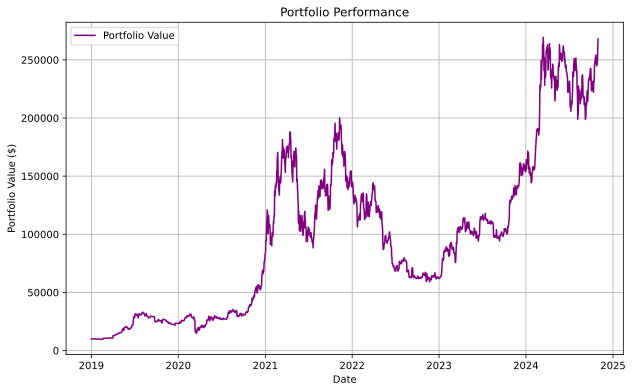

Sharpe Ratio: 1.243
CAGR: 0.755
Cumulative Returns: 25.661
Variance: 0.000983
CVaR: -0.070209
Final Portfolio Value: 266614.36


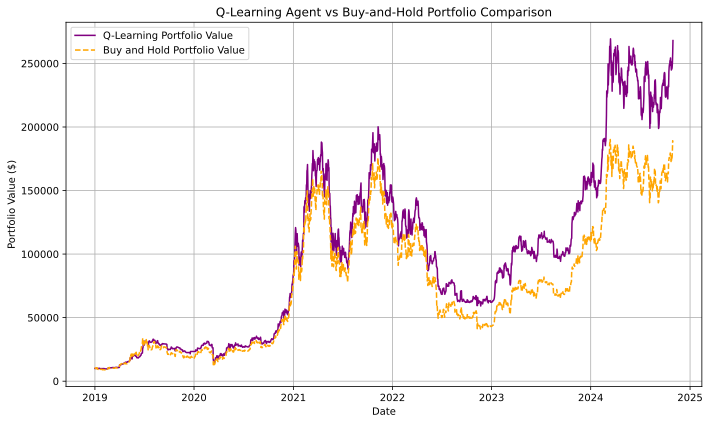

Q-Learning Final Portfolio Value: $268018.40
Q-Learning Cumulative Returns: 2580.18%
Buy-and-Hold Final Portfolio Value: $188211.69
Buy-and-Hold Cumulative Returns: 1782.12%


In [70]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



BTC_USD = yf.Ticker("BTC-USD")
data = BTC_USD.history(start="2019-01-01", end="2024-10-31")

np.random.seed(42)

#Agent
class QLearningAgent:
    def __init__(self, num_states, num_actions, alpha, gamma):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = np.zeros((num_states, num_actions))

#Q update rule
    def update_q_table(self, state, action, reward, next_state):
        max_q_value = np.max(self.q_table[next_state])
        self.q_table[state, action] += self.alpha * (reward + self.gamma * max_q_value - self.q_table[state, action])



#Epsilon-greedy
    def choose_action(self, state, epsilon):
        if np.random.uniform() < epsilon:
            return np.random.choice(self.num_actions)
        return np.argmax(self.q_table[state])

#Trading Strategy
def trading_strategy(data, q_agent, initial_investment, epsilon_decay_rate=0.0075):
    total_reward = 0
    portfolio_value = [initial_investment]
    bitcoin_held = 0
    trades = []

    total_steps = len(data)

    for i in range(total_steps):
        epsilon = max(0.01, 1 * np.exp(-epsilon_decay_rate * i))

        state = 1 if bitcoin_held > 0 else 0

        # Choose action
        action = q_agent.choose_action(state, epsilon)

        # Action 1: Buy (state 0 -> 1)
        if action == 1 and state == 0:
            bitcoin_held = portfolio_value[-1] / data['Close'].iloc[i]
            trades.append(('BUY', data.index[i], data['Close'].iloc[i], bitcoin_held))

        # Action 0: Sell (state 1 -> 0)
        elif action == 0 and state == 1:
            portfolio_value[-1] = bitcoin_held * data['Close'].iloc[i]
            bitcoin_held = 0
            trades.append(('SELL', data.index[i], data['Close'].iloc[i], 0))

        # Action 2: Hold
        elif action == 2:
            trades.append(('HOLD', data.index[i], data['Close'].iloc[i], bitcoin_held))

        # Calculate reward (percentage change in portfolio value)
        reward = (portfolio_value[-1] - portfolio_value[-2]) / portfolio_value[-2] if len(portfolio_value) > 1 else 0
        total_reward += reward

        next_state = 1 if bitcoin_held > 0 else 0
        q_agent.update_q_table(state, action, reward, next_state)

        if bitcoin_held > 0:
            portfolio_value.append(bitcoin_held * data['Close'].iloc[i])
        else:
            portfolio_value.append(portfolio_value[-1])

    return total_reward, portfolio_value, trades


# Initialize agent and run strategy
initial_investment = 10000
q_agent = QLearningAgent(num_states=2, num_actions=3, alpha=0.2, gamma=0.99)

# Run trading strategy
total_reward, portfolio_value, trades = trading_strategy(data, q_agent, initial_investment)

# Metrics
returns = np.diff(portfolio_value) / portfolio_value[:-1]
sharpe_ratio = np.sqrt(365) * np.mean(returns) / np.std(returns)  # Sharpe ratio
cagr = (portfolio_value[-1] / portfolio_value[0]) ** (1 / (len(data) / 365)) - 1  # CAGR
cumulative_returns = (portfolio_value[-1] - portfolio_value[0]) / portfolio_value[0]
variance = np.var(returns)
cvar = np.mean(returns[returns < np.percentile(returns, 5)])

# Trim portfolio_value to match the length of data.index
portfolio_value_trimmed = portfolio_value[:len(data.index)]

# Plot portfolio performance
plt.figure(figsize=(10, 6))
plt.plot(data.index, portfolio_value_trimmed, label='Portfolio Value', color='purple')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Performance')
plt.legend()
plt.grid(True)
plt.show()

# Print metrics
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"CAGR: {cagr:.3f}")
print(f"Cumulative Returns: {cumulative_returns:.3f}")
print(f"Variance: {variance:.6f}")
print(f"CVaR: {cvar:.6f}")
print(f"Final Portfolio Value: {portfolio_value[-1]:.2f}")

# Compare Portfolio Value with Buy-and-Hold Strategy
buy_and_hold_portfolio_value = (initial_investment / data['Close'].iloc[0]) * data['Close']
buy_and_hold_portfolio_value_trimmed = buy_and_hold_portfolio_value[:len(data.index)]

# Plot comparison of portfolio value and Buy-and-Hold strategy
plt.figure(figsize=(10, 6))
plt.plot(data.index, portfolio_value_trimmed, label='Q-Learning Portfolio Value', color='purple')
plt.plot(data.index, buy_and_hold_portfolio_value_trimmed, label='Buy and Hold Portfolio Value', linestyle='--', color='orange')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Q-Learning Agent vs Buy-and-Hold Portfolio Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final portfolio value and cumulative returns comparison
q_learning_final_value = portfolio_value_trimmed[-1]
buy_and_hold_final_value = buy_and_hold_portfolio_value_trimmed.iloc[-1]

q_learning_cumulative_returns = (q_learning_final_value - initial_investment) / initial_investment
buy_and_hold_cumulative_returns = (buy_and_hold_final_value - initial_investment) / initial_investment

# Print Results
print(f"Q-Learning Final Portfolio Value: ${q_learning_final_value:.2f}")
print(f"Q-Learning Cumulative Returns: {q_learning_cumulative_returns * 100:.2f}%")
print(f"Buy-and-Hold Final Portfolio Value: ${buy_and_hold_final_value:.2f}")
print(f"Buy-and-Hold Cumulative Returns: {buy_and_hold_cumulative_returns * 100:.2f}%")